# Binary Classifier for Bio-Imaging

### Loading and Splitting Data for Training and Validation

In [ ]:
# Import Packages
import pandas as pd 
import numpy as np
import os
import shutil
import statistics
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# List of all conditions paths: tuple of (path to csv with intensities and img paths, directory with images)
all_conditions = [("/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/filtered_tables/jasp_NCR_table.csv", "/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/jasp_cells_norm/"), 
                  ("/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/filtered_tables/latb_NCR_table.csv", "/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/latb_cells_norm/"), 
                  ("/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/filtered_tables/sfm_NCR_table.csv", "/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/sfm_cells_norm/"), 
                  ("/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/filtered_tables/vc_NCR_table.csv", "/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/vc_cells_norm/"),
                  ("/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/filtered_tables/serum_NCR_table.csv", "/content/gdrive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/Filtered/serum_cells_norm/")]

In [ ]:
# Plot histogram of Nuclear to Cytoplasmic ratios 
for condition in all_conditions:
  df = pd.read_csv(condition[0])
  
  ncrs = []
  for index, row in df.iterrows():
    ratio = 0
    if (row['Cytoplasmic mean intensitiy'] != 0 and row['Nuclear mean intensity'] != 0):
      ratio = row['Nuclear mean intensity'] / row['Cytoplasmic mean intensitiy']
      ncrs.append(ratio)

  new_df = pd.DataFrame(ncrs, columns = ['ncr'])
  new_df['ncr'].hist(alpha=0.5, label = condition[1].split('/')[-2], range = (1,3))
  print (condition[1].split('/')[-2], np.nanmedian(ncrs))

plt.xlabel('Nuclear to Cytoplasmic Ratio')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
# Split data (only actin channels) into respective directories 

for condition in all_conditions:

    # Path to NCR datatable and create dataframe
    df = pd.read_csv(condition[0])

    # Change paths of all images to google drive path 
    gd_path = condition[1]
        
    # Create lists to hold paths of two categories 
    above_list = []
    below_list = []

    # Set thresholds 
    t_one = (3.5,5.5)
    t_two = (9,40)

    # Calculate ratio for each row and add to designated dataframe
    for index, row in df.iterrows():
      ratio = 0
      if (row['Cytoplasmic mean intensitiy'] != 0 and row['Nuclear mean intensity'] != 0):
          ratio = row['Nuclear mean intensity'] / row['Cytoplasmic mean intensitiy']
          tail = os.path.split(row['File Path'])[1]
          
      if ratio >= t_two[0] and ratio <= t_two[1]:
          above_list.append((tail, ratio))
      elif ratio >= t_one[0] and ratio <= t_one[1]:
          below_list.append((tail, ratio))

    # Create resulting directory and move files to correct directories 
    train_dir = os.path.split(condition[0])[0] + '/training'
    validation_dir = os.path.split(condition[0])[0] + '/validation'

    high_path_training = os.path.split(condition[0])[0] + '/training/high_dir'
    high_path_val = os.path.split(condition[0])[0] + '/validation/high_dir'
    high_path_testing = os.path.split(condition[0])[0] + '/testing/high_dir'

    low_path_training = os.path.split(condition[0])[0] + '/training/low_dir'
    low_path_val = os.path.split(condition[0])[0] + '/validation/low_dir'
    low_path_testing = os.path.split(condition[0])[0] + '/testing/low_dir'

    for path in [high_path_training, high_path_val, high_path_testing, low_path_training, low_path_val, low_path_testing]:
        if os.path.isdir(path) == False:
            os.makedirs(path)

    # Get partitions for training, validation, testing (70%, 20%, 10% respectively)
    above_count = len(above_list)
    high_train = [0, round(above_count * 0.7)]
    high_val = [high_train[1], round(high_train[1] + (above_count * 0.2))]
    high_test = [high_val[1], above_count]
    high_ranges = [(high_train, high_path_training), (high_val, high_path_val), (high_test, high_path_testing)]

    below_count = len(below_list)
    low_train = [0, round(below_count * 0.7)]
    low_val = [low_train[1], round(low_train[1] + (below_count * 0.2))]
    low_test = [low_val[1], below_count]
    low_ranges = [(low_train, low_path_training), (low_val, low_path_val), (low_test, low_path_testing)]

    for each in high_ranges:
        rang = each[0]
        temp = above_list[rang[0]:rang[1]]
        for img in temp:
            new_path = each[1] + '/' + img[0]
            image = Image.open(gd_path + img[0])
            image.seek(1)
            image.save(new_path)

    for each in low_ranges:
        rang = each[0]
        temp = below_list[rang[0]:rang[1]]
        for img in temp:
            new_path = each[1] + '/' + img[0]
            image = Image.open(gd_path + img[0])
            image.seek(1)
            image.save(new_path)

In [ ]:
# See sizes of each dataset
print('Low Training: ' + str(len(os.listdir(os.path.join(low_path_training)))))
print('High Training: ' + str(len(os.listdir(os.path.join(high_path_training)))))
print('Low Validation: ' + str(len(os.listdir(os.path.join(low_path_val)))))
print('High Validation: ' + str(len(os.listdir(os.path.join(high_path_val)))))
print('Low Test: ' + str(len(os.listdir(os.path.join(low_path_testing)))))
print('High Test: ' + str(len(os.listdir(os.path.join(high_path_testing)))))


lo training Num: 2225
hi training Num: 1569
lo validation Num: 636
hi validation Num: 449
lo test Num: 318
hi test Num: 223


### Model and Train Binary Classifier

In [ ]:
# Import Packages
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

'2.4.3'

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=30,
        class_mode='binary',
        shuffle = False) 

Found 1440 images belonging to 2 classes.
Found 411 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 150, 150, 3)
labels batch shape: (50,)


In [ ]:
#Be sure to set batch size equal or near (num of images) / epochs
history = model.fit(
      train_generator,
      steps_per_epoch=28,  
      epochs=14,
      validation_data=validation_generator,
      validation_steps=13)

Epoch 1/14
28/28 [==============================] - 420s 15s/step - loss: 0.6502 - acc: 0.6565 - val_loss: 0.6251 - val_acc: 0.6974
Epoch 2/14
28/28 [==============================] - 4s 158ms/step - loss: 0.6105 - acc: 0.6839 - val_loss: 0.5869 - val_acc: 0.7487
Epoch 3/14
28/28 [==============================] - 4s 159ms/step - loss: 0.5767 - acc: 0.7327 - val_loss: 0.5752 - val_acc: 0.7026
Epoch 4/14
28/28 [==============================] - 4s 160ms/step - loss: 0.4887 - acc: 0.7809 - val_loss: 0.4784 - val_acc: 0.7590
Epoch 5/14
28/28 [==============================] - 4s 159ms/step - loss: 0.4820 - acc: 0.7901 - val_loss: 0.4783 - val_acc: 0.7718
Epoch 6/14
28/28 [==============================] - 4s 157ms/step - loss: 0.4574 - acc: 0.7869 - val_loss: 0.5779 - val_acc: 0.7256
Epoch 7/14
28/28 [==============================] - 4s 160ms/step - loss: 0.4379 - acc: 0.8018 - val_loss: 0.5874 - val_acc: 0.7077
Epoch 8/14
28/28 [==============================] - 5s 164ms/step - loss: 0.

In [ ]:
model.save('results_1.h5')

### Get Metrics 

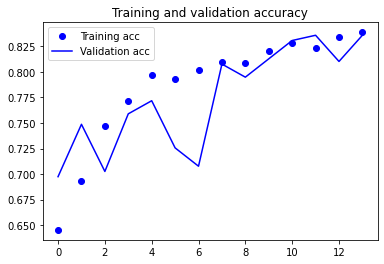

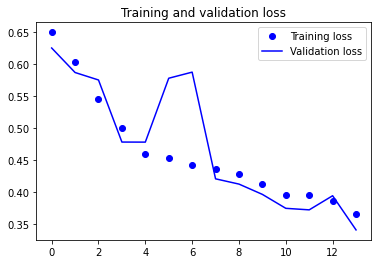

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_true,y_pred)

auc = auc(fpr, tpr)

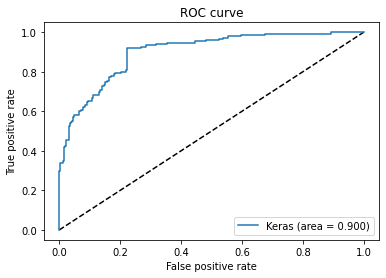

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


num_of_val_samples = 1085
batch_size = 20

Y_pred = model.predict(validation_generator, num_of_val_samples //batch_size + 1)
y_pred = np.argmax(Y_pred, axis = 1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['low_validation', 'high_validation']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[261   0]
 [150   0]]
Classification Report
                 precision    recall  f1-score   support

 low_validation       0.64      1.00      0.78       261
high_validation       0.00      0.00      0.00       150

       accuracy                           0.64       411
      macro avg       0.32      0.50      0.39       411
   weighted avg       0.40      0.64      0.49       411



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### With Data Augmentation


In [ ]:
datagen = ImageDataGenerator(
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='binary',
        shuffle = False)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=35,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=68,
      epochs=12,
      validation_data=validation_generator,
      validation_steps=24)

Found 3440 images belonging to 2 classes.
Found 860 images belonging to 2 classes.
Epoch 1/12
68/68 [==============================] - 25s 362ms/step - loss: 0.7013 - acc: 0.4414 - val_loss: 0.6729 - val_acc: 0.5464
Epoch 2/12
68/68 [==============================] - 24s 354ms/step - loss: 0.6978 - acc: 0.5270 - val_loss: 0.6639 - val_acc: 0.5452
Epoch 3/12
68/68 [==============================] - 24s 356ms/step - loss: 0.6792 - acc: 0.5919 - val_loss: 0.6134 - val_acc: 0.7369
Epoch 4/12
68/68 [==============================] - 24s 355ms/step - loss: 0.6710 - acc: 0.5849 - val_loss: 0.6115 - val_acc: 0.6917
Epoch 5/12
68/68 [==============================] - 24s 354ms/step - loss: 0.6560 - acc: 0.6315 - val_loss: 0.5565 - val_acc: 0.7012
Epoch 6/12
68/68 [==============================] - 24s 356ms/step - loss: 0.6702 - acc: 0.6372 - val_loss: 0.5299 - val_acc: 0.7738
Epoch 7/12
68/68 [==============================] - 24s 353ms/step - loss: 0.6365 - acc: 0.6654 - val_loss: 0.5210 - va

In [ ]:
model.save('result_2.h5')

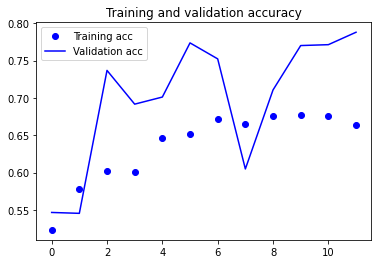

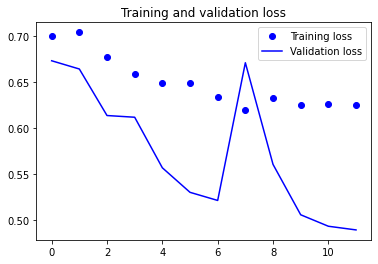

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

In [ ]:
con_mat = tf.math.confusion_matrix(y_true, y_pred).numpy()
tn, fp, fn, tp = con_mat.ravel()

In [ ]:
con_mat_norm = np.around(con_mat.astype('float')/
                         con_mat.sum(axis =1)[:,np.newaxis],
                         decimals = 1)
classes = (0,1) 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

In [ ]:
test_dir = '/content/drive/Shareddrives/Senior_Design_Team_2020-2021/Senior_Design_2020-2021/Training_Data/Final Training Data/Cells/ClassifierData/testing'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=None,
        class_mode='binary')


In [ ]:
tst_acc = test.history['acc']
test_acc = test.history['val_acc']
tst_loss = test.history['loss']
test_loss = test.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()